<a href="https://colab.research.google.com/github/komert-mario/MWIT_POSN_2020/blob/main/IMMCnajaaaaaa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lmfit
!pip install spicy
!pip install fsspec

     |████████████████████████████████| 307kB 4.9MB/s 
     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 256kB 7.5MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=f919a74d9a1596c2de3c6be8935052d8c3cb1eebefb436e07783c4dcd4df2d6a
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=bd3fb124dc1145447c89550419233fefea74a2a69ef781f1238059544c27c92c
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval
     |████████████████████████████████| 112kB 6.0MB/s 


In [ ]:
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.stats as stats
import matplotlib.pyplot as plt
from lmfit import Model
from datetime import date
import os

In [ ]:
wta_match_2018 = pd.read_csv('https://github.com/JeffSackmann/tennis_wta/raw/master/wta_matches_2018.csv')

# Define Function


In [ ]:
def elo_calc(winner_name, loser_name, score_str, date_now, dict_elo, dict_prev):
    who_won = 1

    ## Set new ELOs and change ELOs due to inactivity
    if winner_name not in dict_elo:
      dict_elo[winner_name] = 1200
      dict_prev[winner_name] = date_now
    elif dict_elo[winner_name] > 1200:
      date_prev = str(dict_prev[winner_name])
      dict_prev[winner_name]=date_now
      date_now = str(date_now)
      d0=date(int(date_prev[:4]), int(date_prev[4:6]), int(date_prev[6:8]))
      d1=date(int(date_now[:4]), int(date_now[4:6]), int(date_now[6:8]))
      delta = d1 - d0
      day_change = delta.days

      if day_change > 28:
        dict_elo[winner_name] = (dict_elo[winner_name] - 1200)/(1 + 1.001 ** (day_change/7)) +1200

    date_now =str(date_now)

    if loser_name not in dict_elo:
      dict_elo[loser_name] = 1200
      dict_prev[loser_name] = date_now
    elif dict_elo[loser_name] > 1200:
      date_prev = str(dict_prev[loser_name])
      dict_prev[loser_name]=date_now
      date_now = str(date_now)
      d0=date(int(date_prev[:4]), int(date_prev[4:6]), int(date_prev[6:8]))
      d1=date(int(date_now[:4]), int(date_now[4:6]), int(date_now[6:8]))
      delta = d1 - d0
      day_change = delta.days

      if day_change > 28:
        dict_elo[loser_name] = (dict_elo[loser_name] - 1200)/(1 + 1.001 ** (day_change/7)) +1200




    score_list = score_str.split(' ')

    for score in score_list:
      if score == 'W/O' or score == 'RET':
        continue
      try:
        score1, score2 = score.split('-')
      except:
        break

      try:
        score1 = int(score1)
      except:
        break

      if '(' not in score2:

        try:
          score2 = int(score2)
        except:
          break

        if score1 > score2:
          score_win = score1
          score_lose = score2
        else:
          score_win = score1
          score_lose = score2
      else:
        len_score2 = len(score2)
        for i in range(len_score2):
          if score2[i] == '(':
            mul=1
            tie_score2=0
            for j in range(i+1,100):
              if score2[j] ==')':
                break
              tie_score2 += int(score2[j])
              mul*=10
        tmp=0
        mul=1
        for i in range(len_score2):
          if score2[i] == '(':
            break
          tmp += int(score2[i])
          mul *= 10

        score2 = int(tmp)
        if score1 > score2:
          score2 += tie_score2
          if tie_score2 <=5:
            score1 += 7
          else:
            score1 += tie_score2 + 2
          score_win = score1
          score_lose = score2
        
        elif score1 < score2:
          score1 += tie_score2
          if tie_score2 <=5:
            score2 += 7
          else:
            score2 += tie_score2 + 2
          who_won = 2
          score_win = score2
          score_lose = score1


      #score
      score_win = int(score_win)
      score_lose = int(score_lose)

      if score_win - score_lose == 2:
        d=1.8
      elif score_win - score_lose == 3:
        d=2
      else:
        d=2+0.1*(score_win - score_lose)
      
      if d<1:
        break

      if score_win == 7 or score_win == 6:
        s=1
      else:
        s=1.5

      if score_lose < 12:
        t=1
      else:
        t=score_lose - 10

      x=5
      f=(d/s) ** (1/t)
      k_factor = f*x
  
      change = k_factor * (1 - (1+10**((dict_elo[winner_name]-dict_elo[loser_name])/600) )**(-1))

      if who_won == 1:

        dict_elo[winner_name] += change
        dict_elo[loser_name] -= change
      elif who_won == 2:
        dict_elo[winner_name] -= change
        dict_elo[loser_name] += change 

      # dict_elo[winner_name] = max(0,dict_elo[winner_name])
      # dict_elo[loser_name] = max(0,dict_elo[loser_name])

  
# elo_calc(winner_name='WINNER1', loser_name='LOSER1', score_mix = '6-0' )
# print(dict_elo)

In [ ]:
def rerank(player_name, date_now, dict_elo, dict_prev):
    if player_name not in dict_elo:
      dict_elo[player_name] = 1200
      dict_prev[player_name] = date_now
    elif dict_elo[player_name] > 1200:
      date_prev = str(dict_prev[player_name])
      dict_prev[player_name]=date_now
      date_now = str(date_now)
      d0=date(int(date_prev[:4]), int(date_prev[4:6]), int(date_prev[6:8]))
      d1=date(int(date_now[:4]), int(date_now[4:6]), int(date_now[6:8]))
      delta = d1 - d0
      day_change = delta.days
    
      if day_change < 4*7: 
        tmp=1
      else:
        dict_elo[player_name] = (dict_elo[player_name] - 1200)/(1 + 1.001 ** (100*day_change/7 - 1000)) +1200

In [ ]:
def display(dict_elo):
  df_elo = pd.DataFrame(list(dict_elo.items()), columns = ['Player Name', 'ELO'])

  df_elo_sorted = df_elo.sort_values(by='ELO', ascending = False)
  df_elo_sorted = df_elo_sorted.reset_index(drop=True)
  df_elo_sorted.index +=1
  print(df_elo_sorted.head(15))

  mid = df_elo['ELO'].mean()
  sd =  df_elo['ELO'].std()
  num_player = df_elo.shape[0]
  print('Number of Players:', num_player)
  print('mean:', mid)
  print('STD:', sd)
  df_elo.plot.hist(bins=50)


            Player Name          ELO
1           Aaron BROWN  1747.795080
2          Femi OGUNODE  1603.383608
3   Henricho BRUINTJIES  1601.374829
4      Churandy MARTINA  1588.590601
5         Mosito LEHATA  1561.915804
6           Jeff PORTER  1508.067724
7         Peimeng ZHANG  1468.385486
8   Christophe LEMAITRE  1453.847930
9            Zhenye XIE  1413.115649
10          Yohan BLAKE  1391.682181
11     Johnathan CABRAL  1376.516031
12         Akeem HAYNES  1356.673393
13       Keston BLEDMAN  1345.183436
14         Luke BEZZINA  1335.250971
15     Gabriel MVUMVURE  1319.982266
Number of Players: 316
mean: 1141.0943304619261
STD: 175.57471014951219


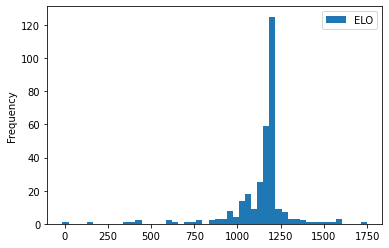

In [ ]:
display(sprint_elo)

#CODE


In [ ]:
# grandslam_name =['Wimbledon', 'Roland Garros', 'US Open', 'Australia Open']

# grandslam = wta_match_2018.loc[wta_match_2018['tourney_name'].isin(grandslam_name)]
# grandslam.reset_index()

# grandslam_elo ={}

# len_grandslam = grandslam.shape[0]

# ss = set()

# for i in range(len_grandslam):
#   player1 = grandslam.iloc[i]['winner_name']
#   player2 = grandslam.iloc[i]['loser_name']

#   ss.add(player1)
#   ss.add(player2)
#   try:
#     grandslam_elo[player1] = wta_elo[player1]
#   except:
#     grandslam_elo[player1] = 1200

#   try:
#     grandslam_elo[player2] = wta_elo[player2]
#   except:
#     grandslam_elo[player2] = 1200

# for i in range(len_grandslam):
#   winner = grandslam.iloc[i]['winner_name']
#   loser = grandslam.iloc[i]['loser_name']
#   date_tour = grandslam.iloc[i]['tourney_date']

#   score_mix = grandslam.iloc[i]['score']
#   score_list = score_mix.split(' ')

#   elo_calc(winner_name=winner, loser_name=loser, score_str=score_mix, date_now=date_tour)

#Athletics Sprint Results in all Heats for 2004 - 2016 Olympics for Men



In [ ]:
def elo_calc_sprint(winner_name, loser_name, time_win, time_lose, date_now, dict_elo, dict_prev):
    ## Set new ELOs and change ELOs due to inactivity
    if winner_name not in dict_elo:
      dict_elo[winner_name] = 1200
      dict_prev[winner_name] = date_now
    elif dict_elo[winner_name] > 1200:
      date_prev = str(dict_prev[winner_name])
      dict_prev[winner_name]=date_now
      date_now = str(date_now)
      d0=date(int(date_prev[:4]), int(date_prev[4:6]), int(date_prev[6:8]))
      d1=date(int(date_now[:4]), int(date_now[4:6]), int(date_now[6:8]))
      delta = d1 - d0
      day_change = delta.days

      if day_change < 4*7:
        tmp=1
      else:
        dict_elo[winner_name] = (dict_elo[winner_name] - 1200)/(1 + 1.001 ** (100*day_change/7 - 1000)) +1200


    date_now =str(date_now)

    if loser_name not in dict_elo:
      dict_elo[loser_name] = 1200
      dict_prev[loser_name] = date_now
    elif dict_elo[loser_name] > 1200:
      date_prev = str(dict_prev[loser_name])
      dict_prev[loser_name]=date_now
      date_now = str(date_now)
      d0=date(int(date_prev[:4]), int(date_prev[4:6]), int(date_prev[6:8]))
      d1=date(int(date_now[:4]), int(date_now[4:6]), int(date_now[6:8]))
      delta = d1 - d0
      day_change = delta.days

      if day_change < 4*7:
        tmp=1
      else:
        dict_elo[loser_name] = (dict_elo[loser_name] - 1200)/(1 + 1.001 ** (100*day_change/7 - 1000)) + 1200

    #Calculating X from Normal Distribution
    mid = np.mean(list(dict_elo.values()))
    std = np.std(list(dict_elo.values()))

    try:
      z_score_winner = (dict_elo[winner_name] - mid) / std
      z_score_loser = (dict_elo[loser_name] - mid) / std
    except:
      x1=1
      x2=1

    if z_score_winner >= 2 :
      x1 = 5
    elif z_score_winner >= 1 :
      x1 = 4
    elif z_score_winner >= 0 :
      x1 = 3
    elif z_score_winner >= -1 :
      x1 = 2
    else :
      x1 = 1

    if z_score_loser >= 2 :
      x2 = 5
    elif z_score_loser >= 1 :
      x2 = 4
    elif z_score_loser >= 0 :
      x2 = 3
    elif z_score_loser >= -1 :
      x2 = 2
    else :
      x2 = 1
     
    d=time_lose - time_win
    t=time_win + time_lose
    f= 1.05 ** (1/d + 1/t)

      
    k_factor_loss = f*x1
    k_factor_won = f*x2
    

    change_won = k_factor_won * (1 - (1+10**((dict_elo[loser_name]-dict_elo[winner_name])/600) )**(-1))
    change_loss = k_factor_loss * (1 - (1+10**((dict_elo[winner_name]-dict_elo[loser_name])/600) )**(-1))

    dict_elo[winner_name] += change_won
    dict_elo[loser_name] -= change_loss

    # dict_elo[winner_name] = max(0,dict_elo[winner_name])
    # dict_elo[loser_name] = max(0,dict_elo[loser_name])

  
# elo_calc(winner_name='WINNER1', loser_name='LOSER1', score_mix = '6-0' )
# print(dict_elo)

In [ ]:
def rerank_sprint(player_name, date_now, dict_elo, dict_prev):
    if player_name not in dict_elo:
      dict_elo[player_name] = 1200
      dict_prev[player_name] = date_now
    elif dict_elo[player_name] > 1200:
      date_prev = str(dict_prev[player_name])
      dict_prev[player_name]=date_now
      date_now = str(date_now)
      d0=date(int(date_prev[:4]), int(date_prev[4:6]), int(date_prev[6:8]))
      d1=date(int(date_now[:4]), int(date_now[4:6]), int(date_now[6:8]))
      delta = d1 - d0
      day_change = delta.days
    
      if day_change < 1*7: 
        tmp=1
      else:
        dict_elo[player_name] = (dict_elo[player_name] - 1200)/(1 + 1.001 ** (100*day_change/7 - 600)) +1200

In [ ]:
global sprint_elo
sprint_elo  = {}
global sprint_elo
sprint_prev = {}

sprint_result = pd.read_csv('/content/2004-2016-Short-Races.csv', encoding='latin-1' )
df_sprint = pd.DataFrame(sprint_result)
df_sprint = df_sprint[df_sprint['Gender'] == 'M']

tour_name = ['Preliminary', 'Heats', 'Semi', 'Final']

for year in range(2004,2017):

  if year%4!=0:
    continue
  print(year)
  date_tour = str(year)+'01'+'01'
  df_year = df_sprint[df_sprint['Year'] == year]

  for tour in tour_name:
    df_year_tour = df_year[df_year['Round'] == tour]
    
  
# keys=player_name, items = current_elo

    len_df_sprint = df_year_tour.shape[0]

    for i in range(len_df_sprint):
      
      player1 = df_year_tour.iloc[i]['ATHLETE']
      time1 = df_year_tour.iloc[i]['MARK']
      for j in range(i+1,len_df_sprint):
        player2 = df_year_tour.iloc[j]['ATHLETE']
        time2 = df_year_tour.iloc[j]['MARK']

        if type(time1) == 'str':
          time1.strip('Q')
          time1.strip('q')
        if type(time2) == 'str':
          time2.strip('Q')
          time2.strip('q')

        try:
          time1=float(time1)
          time2=float(time2)
        except:
          continue
        if time1 < time2:
          elo_calc_sprint(winner_name=player1, loser_name=player2, time_win = time1, time_lose=time2, date_now = date_tour,dict_elo = sprint_elo, dict_prev = sprint_prev)
      
        elif time1 > time2:
          elo_calc_sprint(winner_name=player2, loser_name=player1, time_win = time2, time_lose=time1, date_now = date_tour,dict_elo = sprint_elo, dict_prev = sprint_prev)

           

        

2004


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


2008
2012
2016


In [ ]:
date_tour = str(2016) + '01' + '01'
for key in sprint_elo.keys():
  rerank_sprint(player_name=key, date_now=date_tour, dict_elo=sprint_elo, dict_prev=sprint_prev)

              Player Name          ELO
1         Souhalia ALAMOU  1758.947034
2            Nilson ANDRÈ  1756.360452
3             Aaron BROWN  1747.795080
4            Femi OGUNODE  1603.383608
5     Henricho BRUINTJIES  1601.374829
6        Churandy MARTINA  1588.590601
7            Sandro VIANA  1566.019864
8        Masashi ERIGUCHI  1565.612144
9      Dmytro HLUSHCHENKO  1564.485054
10          Mosito LEHATA  1561.915804
11          Seng Song POH  1543.145788
12          Warren FRASER  1534.291945
13  Ángel David RODRÍGUEZ  1526.305531
14            Jeff PORTER  1508.067724
15         Aleksey DREMIN  1483.187199
Number of Players: 316
mean: 1169.3941440165327
STD: 201.51287182501991


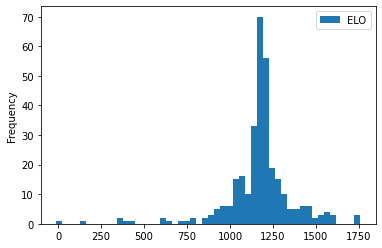

In [ ]:
display(sprint_elo)

#WTA Grand Slam 2018 Fourth Round to Final

In [ ]:
global wta_elo
global wta_prev
wta_elo = {}
wta_prev = {}
for i in range(2018,2019):
  wta_matches_csv = pd.read_csv('/content/Grandslam2018.csv')
  wta_matches_i = pd.DataFrame(wta_matches_csv)
# keys=player_name, items = current_elo

  len_wta_matches_i = wta_matches_i.shape[0]
  for j in range(len_wta_matches_i):
    
    winner = wta_matches_i.iloc[j]['winner_name']
    loser = wta_matches_i.iloc[j]['loser_name']
    date_tour = wta_matches_i.iloc[j]['tourney_date']

    score_mix = str(wta_matches_i.iloc[j]['score'])

    elo_calc(winner_name=winner, loser_name=loser, score_str=score_mix, date_now = date_tour,dict_elo=wta_elo,dict_prev=wta_prev)
  print('year:', i,' player count:',len(wta_elo))

# print(wta_elo)


year: 2018  player count: 68


In [ ]:
date_tour= str(2018) + '01' +'01'
for name in wta_elo.keys():
  rerank(player_name=name, date_now = date_tour,dict_elo=wta_elo, dict_prev=wta_prev)

                   Player Name          ELO
1              Serena Williams  1262.889003
2             Angelique Kerber  1257.500083
3                 Simona Halep  1254.375068
4           Caroline Wozniacki  1242.224992
5                 Madison Keys  1239.365038
6                  Naomi Osaka  1235.588106
7         Carla Suarez Navarro  1229.365096
8         Anastasija Sevastova  1229.040461
9              Sloane Stephens  1226.352943
10         Marketa Vondrousova  1226.132877
11         Alison Van Uytvanck  1224.726176
12            Garbine Muguruza  1217.907234
13               Julia Goerges  1215.043765
14            Yulia Putintseva  1213.763376
15  Barbora Zahlavova Strycova  1208.391308
Number of Players: 68
mean: 1198.2842415110297
STD: 21.086753210955703


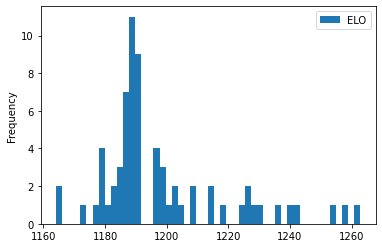

In [ ]:

display(wta_elo)

#WTA Tournament from 1948 to 2018

In [ ]:
# input the winner => player1 and the loser => player2
global wta_elo
global wta_prev
wta_elo = {}
wta_prev = {}

for i in range(2018,2019):
  f= 'wta_matches_' +str(i) +'.csv'

  wta_matches_csv = pd.read_csv('https://github.com/JeffSackmann/tennis_wta/raw/master/' + f)
  wta_matches_i = pd.DataFrame(wta_matches_csv)

  len_wta_matches_i = wta_matches_i.shape[0]
  for j in range(len_wta_matches_i):
    
    winner = wta_matches_i.iloc[j]['winner_name']
    loser = wta_matches_i.iloc[j]['loser_name']
    date_tour = wta_matches_i.iloc[j]['tourney_date']

    score_mix = str(wta_matches_i.iloc[j]['score'])

    elo_calc_nutch(winner_name=winner, loser_name=loser, score_str=score_mix, date_now = date_tour,dict_elo=wta_elo,dict_prev=wta_prev)
  print('year:', i,' player count:',len(wta_elo))

# print(wta_elo)

In [ ]:
date_tour= str(2018) + '01' +'01'
for name in wta_elo.keys():
  rerank(player_name=name, date_now = date_tour,dict_elo=wta_elo, dict_prev=wta_prev)

In [ ]:
# Displaying the ELO Rating distribution
display(wta_elo)

#Letter's Program

In [ ]:
print("What's your gender ? : (Male / Female)")
sex = input()

print("What's your name ? :")
DTS_name = input()

if sex == 'Male' or sex == 'male' :
  print('Hi, Mr.%s' %DTS_name)
else :
  print("Hi, Mrs.%s" %DTS_name)

print('This is GFinder, a program to calculate players\' rating based on our mathematical model')
print('How to use:')
print('Enter the required information to the program')
print('We hope you to like it')
print('Thank you')

print('*************** S T A R T - G F i n d e r ***************')

global letter_elo
letter_elo = {}
global letter_prev
letter_prev = {}

i=1
while 1 :
  print('Match %d :' %i)
  print('Enter match date : (YYYYMMDD)')
  tour_date=input()
  
  print('Enter winner name : ')
  winner = input()


  print('Enter loser name : ')
  loser = input()

  print('Does this match has a Tiebreaker? : (Y/N)')
  tie=str(input())

  if tie =='Y':
    print('Enter loser\'s tiebreaker score : ')
    st2 = int(input())
    score_mix = str(s1) + '-' + str(s2) +'(' + str(st2) + ')'
  else:
    print('Enter winner\'s score : ')
    s1 = int(input())
    print('Enter loser\'s score : ')
    s2 = int(input())
    score_mix = str(s1) + '-' + str(s2)
  
  elo_calc(winner_name=winner,loser_name=loser,score_str=score_mix, date_now=tour_date, dict_elo=letter_elo,dict_prev=letter_prev)

  i=i+1
  
  print('ELO Rating Updated Completed')
  print('Continue the Program? : (Y/N)')
  con = str(input())
  if con == 'N':
    break

print('ELO Ranking')
display(letter_elo)